All details about the competition (as well as training and test data) can be found [here](https://www.kaggle.com/competitions/unifesp-x-ray-body-part-classifier).

In [1]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.9 MB/s 


In [2]:
!pip install albumentations==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 6.3 MB/s 
     |████████████████████████████████| 47.8 MB 2.2 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
!pip uninstall opencv-python-headless==4.5.5.62

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-09fe7800.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [5]:
!pip install opencv-python-headless==4.5.2.52

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from pydicom import dcmread
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shutil
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from itertools import combinations
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import f1_score
import sys
from tqdm import tqdm

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/archive_unifes.zip -d /content/unifesp-xray-bodypart-classification

In [11]:
TRAIN_IMAGES_FOLDER = '/content/unifesp-xray-bodypart-classification/train/train/train'
TRAIN_TARGETS_FILE = '/content/unifesp-xray-bodypart-classification/train.csv'
TEST_IMAGES_FOLDER = '/content/unifesp-xray-bodypart-classification/test/test/test'
ADDITIONAL_TRAIN_FOLDER = '/content/add_train'
SLASH = '/'

SEED = 0

NUMBER_OF_CLASSES = 22

NROWS_SUBPLOTS_FOR_IMAGES_DISPLAY = 4
NCOLS_SUBPLOTS_FOR_IMAGES_DISPLAY = 4

BATCH_SIZE = 64
LR = 1e-4
VALIDATION_SIZE = 0.2
EPOCHS = 10

In [12]:
set_seed(SEED)

In [13]:
train_files_paths = []

for folder in os.listdir(TRAIN_IMAGES_FOLDER):  
    folder_path = TRAIN_IMAGES_FOLDER + SLASH + folder
    for address, dirs, files in os.walk(folder_path):
        if files:
            train_files_paths.append(address + SLASH + files[0])

In [14]:
targets_dataset = pd.read_csv(TRAIN_TARGETS_FILE)
targets_dataset

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3
...,...,...
1733,1.2.826.0.1.3680043.8.498.99711016467406172920...,14
1734,1.2.826.0.1.3680043.8.498.99727280485333900933...,11
1735,1.2.826.0.1.3680043.8.498.99935008698914755885...,3
1736,1.2.826.0.1.3680043.8.498.99969671777553755311...,2


In [15]:
targets_for_images = []

for image_path in train_files_paths:
    file_name = os.path.split(image_path)[1]
    image_id = file_name.split('-')[0]
    target_values = targets_dataset[targets_dataset.SOPInstanceUID == image_id]['Target'].iloc[0]
    if len(target_values) > 3:
        target_values = tuple(map(lambda x: int(x), target_values.split(' ')[:-1]))
    else:
        target_values = int(target_values)
    targets_for_images.append(target_values)

In [16]:
for_dataframe = {'image_paths': train_files_paths, 'image_targets': targets_for_images}
dataset = pd.DataFrame(for_dataframe)

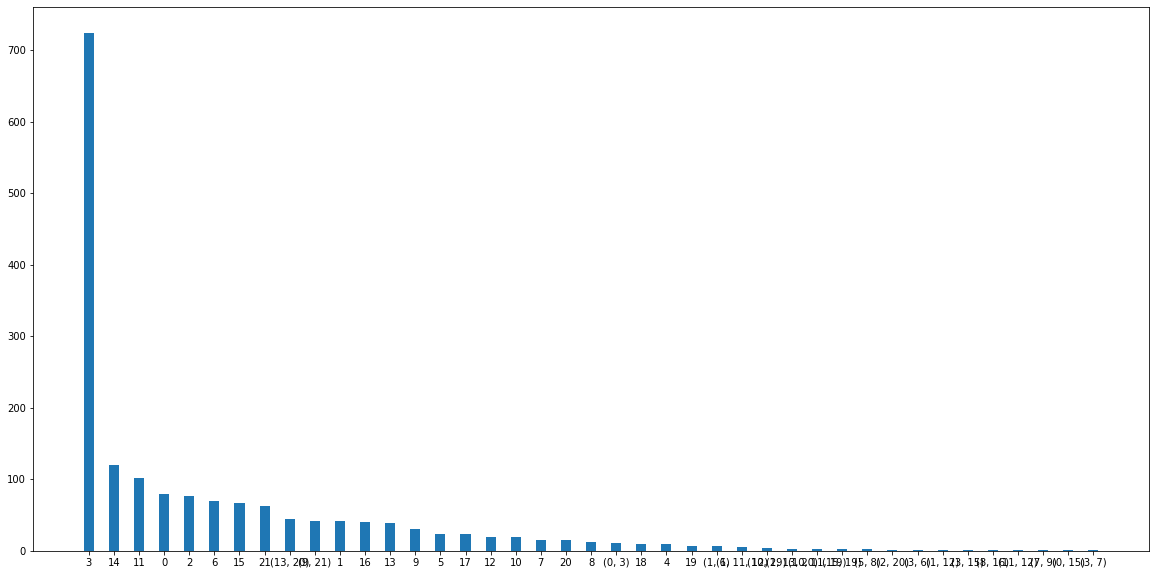

In [17]:
plt.figure(figsize=(20, 10))
plt.bar(x=np.arange(0, len(dataset['image_targets'].unique()) * 2, 2), height=list(dataset['image_targets'].value_counts()))
plt.xticks(ticks=np.arange(0, len(dataset['image_targets'].unique()) * 2, 2), labels=dataset['image_targets'].value_counts().index)
plt.show()

In [18]:
images_count = list(dataset['image_targets'].value_counts())
for index, target in enumerate(dataset['image_targets'].value_counts().index):
    
    possible_paths = dataset[dataset.image_targets == target]['image_paths'].reset_index(drop=True)
    save_path = ADDITIONAL_TRAIN_FOLDER + SLASH + str(target)
    size_of_add_images = images_count[0] - images_count[index]
    
    if size_of_add_images > 0:
        
        for i in range(size_of_add_images):

            image_to_copy = possible_paths[np.random.randint(0, len(possible_paths))]
            _, name_of_image_with_ext = os.path.split(image_to_copy)
            name_of_image_wo_ext, _ = name_of_image_with_ext.split('.dcm')
            name_to_save = name_of_image_wo_ext + f'copy_{i}' + '.dcm'
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            shutil.copy(possible_paths[0], save_path + SLASH + name_to_save)

In [19]:
additional_train_paths = []
additional_train_targets = []
for folder in os.listdir(ADDITIONAL_TRAIN_FOLDER + SLASH):
    for image_path in os.listdir(ADDITIONAL_TRAIN_FOLDER + SLASH + folder):
        additional_train_paths.append(ADDITIONAL_TRAIN_FOLDER + SLASH + folder + SLASH + image_path)
        if len(folder) > 3:
            folder_target = folder.strip('()').split(', ')
            additional_train_targets.append(tuple(map(lambda x: int(x), folder_target)))
        else:
            additional_train_targets.append(int(folder))

In [20]:
additional_dataset = pd.DataFrame({'image_paths': additional_train_paths, 'image_targets': additional_train_targets})
dataset_all = pd.concat([dataset, additional_dataset]).reset_index(drop=True)

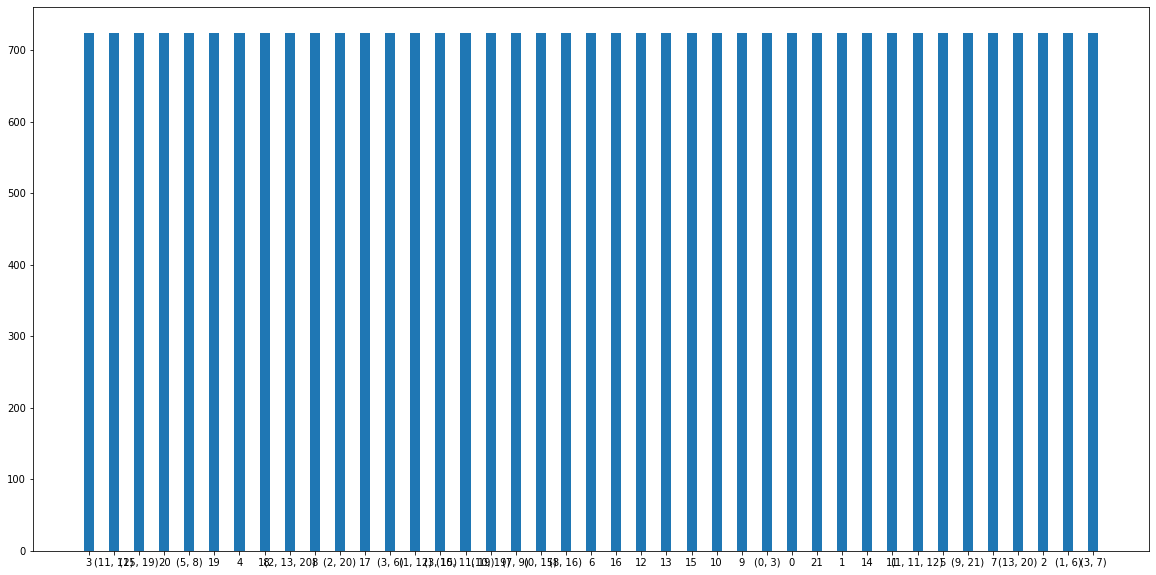

In [21]:
plt.figure(figsize=(20, 10))
plt.bar(x=np.arange(0, len(dataset_all['image_targets'].unique()) * 2, 2), height=list(dataset_all['image_targets'].value_counts()))
plt.xticks(ticks=np.arange(0, len(dataset_all['image_targets'].unique()) * 2, 2), labels=dataset_all['image_targets'].value_counts().index)
plt.show()

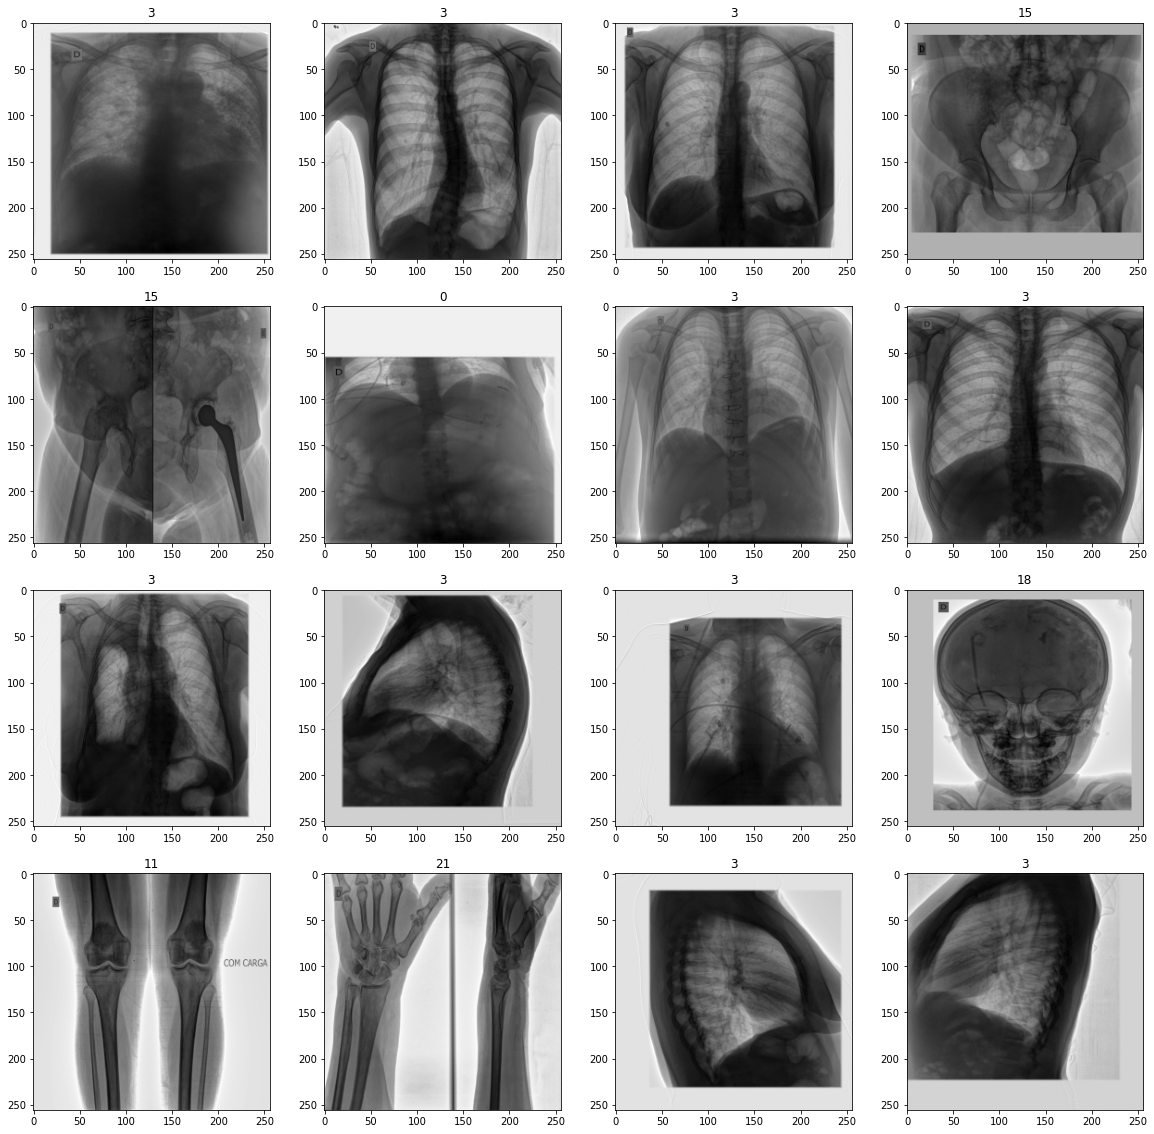

In [22]:
nrows = NROWS_SUBPLOTS_FOR_IMAGES_DISPLAY
ncols = NCOLS_SUBPLOTS_FOR_IMAGES_DISPLAY
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20))
for row in range(nrows):
    for col in range(ncols):
        example = dataset_all.iloc[np.random.randint(0, len(dataset)), :]
        example_file = dcmread(example.iloc[0])
        example_label = example.iloc[1]
        axes[row, col].imshow(example_file.pixel_array, cmap=plt.cm.gray)
        axes[row, col].set_title(example_label)

In [23]:
class XrayDataset(Dataset):
    
    def __init__(self, images_paths, targets=None, transform=None):
        self.images_paths = images_paths
        
        if targets is not None:
            self.targets = targets
        else:
            self.targets = None
    
        if transform is not None:
            self.transformer = transform
        else:
            self.transformer = None
    
    def __len__(self):
        return len(self.images_paths)
    
    def __getitem__(self, idx):
        img_path = self.images_paths[idx]
        image = dcmread(img_path).pixel_array
        image = image.astype('float')
        image = image / 100
        image = image / 255
        
        if self.transformer is not None:
            image = self.transformer(image=image)['image']
        
        if self.targets is not None:
            target = self.targets[idx]
            target_tensor = torch.Tensor().new_zeros(size=(NUMBER_OF_CLASSES,))
            if np.array(target).size > 1:
                for i in target:
                    target_tensor[i] = 1
            else:
                target_tensor[target] = 1
            return image, target_tensor
        
        return image

In [24]:
transformer_train = A.Compose([
    A.RandomContrast(
        limit=(-0.5, 0.5),
        p=0.5,
    ),
    A.Perspective(
        p=0.3,
    ),
    A.Affine(
        rotate=(-30, 30),
    ),
    A.Flip(
        p=0.5,
    ),
    A.OpticalDistortion(),
    A.Blur(
        p=0.2,
    ),
    ToTensorV2()
])

In [25]:
transformer_valid = A.Compose(
    [
     ToTensorV2(),
     ],
)

In [26]:
X = dataset_all['image_paths']
y = dataset_all['image_targets']
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=VALIDATION_SIZE, 
    shuffle=True,
    random_state=SEED
)

In [27]:
X_train, X_val, y_train, y_val = X_train.reset_index(drop=True), X_val.reset_index(drop=True), \
                                 y_train.reset_index(drop=True), y_val.reset_index(drop=True)

In [28]:
train_dataset = XrayDataset(X_train, targets=y_train, transform=transformer_train)
valid_dataset = XrayDataset(X_val, targets=y_val, transform=transformer_valid)

In [29]:
model = models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [30]:
for index, child in enumerate(model.children()):
    if index < 6:
        for param in child.parameters():
            param.requires_grad = False

model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(2048, NUMBER_OF_CLASSES)

In [31]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                             lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [32]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

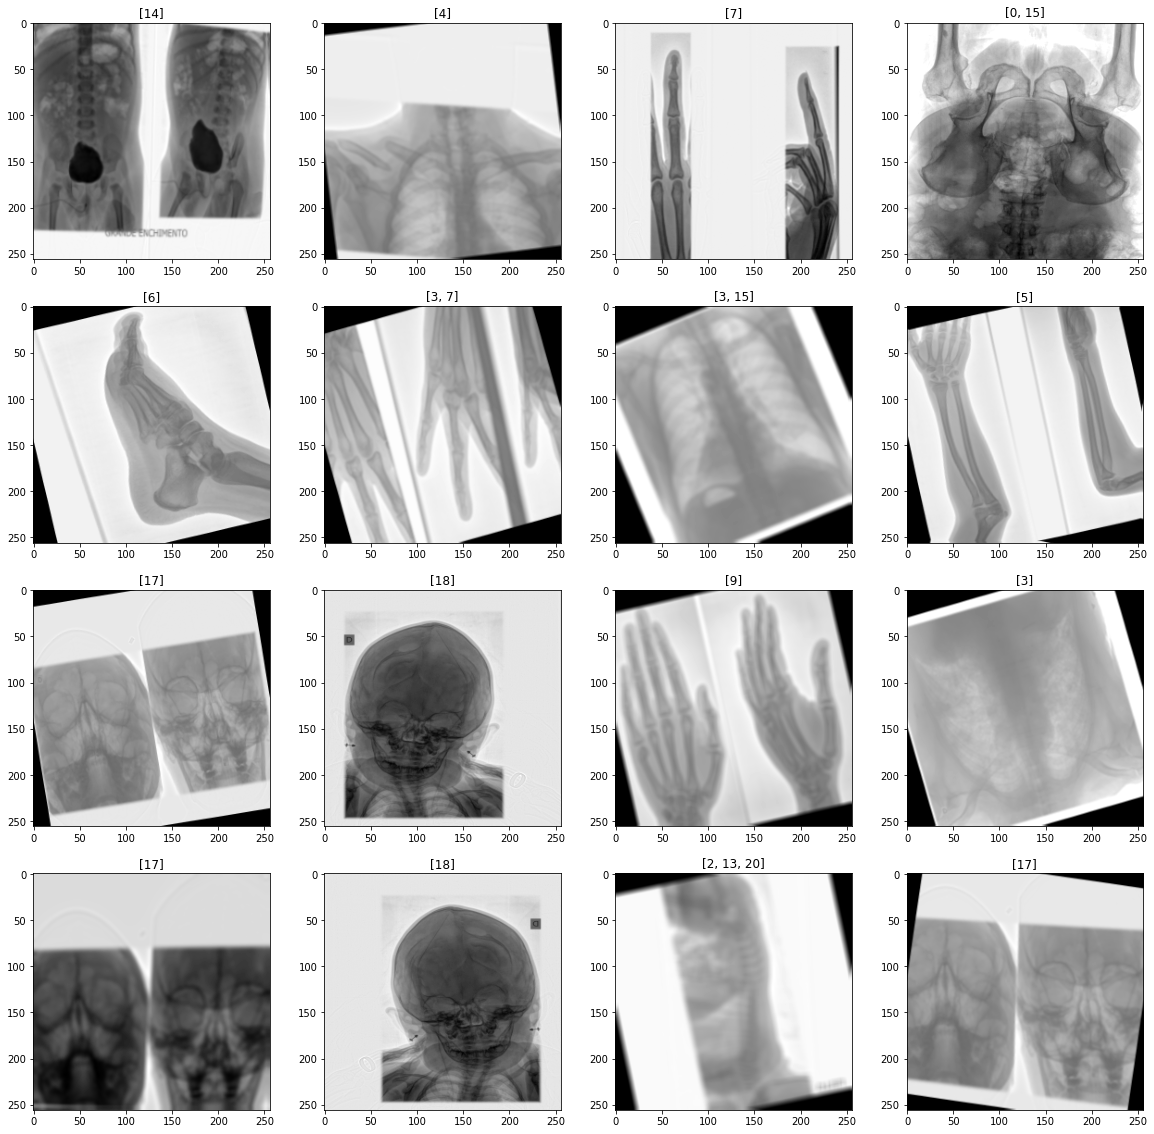

In [33]:
nrows = NROWS_SUBPLOTS_FOR_IMAGES_DISPLAY
ncols = NCOLS_SUBPLOTS_FOR_IMAGES_DISPLAY
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20))
index = 0
images, targets = next(iter(train_dataloader))
for row in range(nrows):
    for col in range(ncols):
        image, target = images[index], targets[index]
        image = torch.squeeze(image)
        axes[row, col].imshow(image, cmap=plt.cm.gray)
        target = np.where(target == 1)[0].tolist()
        axes[row, col].set_title(target)
        index += 1

In [34]:
epochs = EPOCHS

In [35]:
for e in range(epochs):
    
    model.to(device)
    model.train()
    
    train_loss = 0
    index = 0
    y_true_total = np.array([])
    y_pred_total = np.array([])
    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
        
        for X_batch, y_batch in train_dataloader:

            optimizer.zero_grad()

            X_batch = X_batch.to(device, dtype=torch.float)
            y_batch = y_batch.to(device)

            y_pred = torch.sigmoid(model(X_batch))

            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            index += 1
            
            y_true = y_batch.cpu().detach().numpy()
            y_pred = y_pred.cpu().detach().numpy()
            y_pred = np.array(y_pred > 0.5, dtype=float)
            y_true_total = np.append(y_true_total, y_true)
            y_pred_total = np.append(y_pred_total, y_pred)
            
            f1_score_macro = f1_score(y_true_total, y_pred_total, average='macro')
            f1_score_micro = f1_score(y_true_total, y_pred_total, average='micro')
            f1_score_weighted = f1_score(y_true_total, y_pred_total, average='weighted')
            
            prbar.set_description(
                f'Train loss: {round(train_loss / index, 4)} '
                f'Train macro f1-score: {round(f1_score_macro, 4)} '
                f'Train micro f1-score: {round(f1_score_micro, 4)} '
                f'Train weighted f1-score: {round(f1_score_weighted, 4)}'
            )
            prbar.update(1)

    model.eval()
    
    with tqdm(total=len(valid_dataloader), file=sys.stdout) as prbar:
        
        with torch.no_grad():

            eval_loss = 0
            index = 0
            y_true_val_total = np.array([])
            y_pred_val_total = np.array([])
            for X_batch, y_batch in valid_dataloader:

                X_batch = X_batch.to(device, dtype=torch.float)
                y_batch = y_batch.to(device)

                y_pred = torch.sigmoid(model(X_batch))

                valid_loss = criterion(y_pred, y_batch)

                eval_loss += valid_loss.item()
                index += 1
                
                y_true = y_batch.cpu().detach().numpy()
                y_pred = y_pred.cpu().detach().numpy()
                y_pred = np.array(y_pred > 0.5, dtype=float)
                y_true_val_total = np.append(y_true_val_total, y_true)
                y_pred_val_total = np.append(y_pred_val_total, y_pred)
                
                f1_score_macro = f1_score(y_true_val_total, y_pred_val_total, average='macro')
                f1_score_micro = f1_score(y_true_val_total, y_pred_val_total, average='micro')
                f1_score_weighted = f1_score(y_true_val_total, y_pred_val_total, average='weighted')

                prbar.set_description(
                    f'Valid loss: {round(eval_loss / index, 4)} '
                    f'Valid macro f1-score: {round(f1_score_macro, 4)} '
                    f'Valid micro f1-score: {round(f1_score_micro, 4)} '
                    f'Valid weighted f1-score: {round(f1_score_weighted, 4)}'
                )
                prbar.update(1)
    
    scheduler.step(eval_loss / index)

Train loss: 0.0419 Train macro f1-score: 0.9616 Train micro f1-score: 0.9901 Train weighted f1-score: 0.9901: 100%|██████████| 372/372 [14:22<00:00,  2.32s/it]
Valid loss: 0.0049 Valid macro f1-score: 0.9961 Valid micro f1-score: 0.999 Valid weighted f1-score: 0.999: 100%|██████████| 93/93 [01:08<00:00,  1.35it/s]
Train loss: 0.0067 Train macro f1-score: 0.9949 Train micro f1-score: 0.9987 Train weighted f1-score: 0.9987: 100%|██████████| 372/372 [14:11<00:00,  2.29s/it]
Valid loss: 0.0053 Valid macro f1-score: 0.9951 Valid micro f1-score: 0.9987 Valid weighted f1-score: 0.9987: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
Train loss: 0.0048 Train macro f1-score: 0.9957 Train micro f1-score: 0.9989 Train weighted f1-score: 0.9989: 100%|██████████| 372/372 [13:58<00:00,  2.25s/it]
Valid loss: 0.0035 Valid macro f1-score: 0.9972 Valid micro f1-score: 0.9993 Valid weighted f1-score: 0.9993: 100%|██████████| 93/93 [01:01<00:00,  1.51it/s]
Train loss: 0.0043 Train macro f1-score: 0.9961 

In [36]:
test_files_paths = []

for folder in os.listdir(TEST_IMAGES_FOLDER):  
    folder_path = TEST_IMAGES_FOLDER + SLASH + folder
    for address, dirs, files in os.walk(folder_path):
        if files:
            test_files_paths.append(address + SLASH + files[0])

In [37]:
test_dataset = XrayDataset(test_files_paths, transform=transformer_valid)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [38]:
image_names = []
predicted_targets = []

index = 0

with torch.no_grad():
    
    for X_batch in tqdm(test_dataloader):

        X_batch = X_batch.to(device, dtype=torch.float)
        y_pred = torch.sigmoid(model(X_batch))
        y_pred = y_pred.cpu().detach().numpy()
        y_preds_final = np.array(y_pred > 0.5, dtype=float)

        for predicted_target in y_pred:
            
            predicted_target_final = np.array(predicted_target > 0.5, dtype=float)
            
            if len(np.where(predicted_target_final == 1)[0]) == 0:
                
                predicted_target_final = np.array(predicted_target == max(predicted_target), dtype=float)
            
            predicted = np.where(predicted_target_final == 1)[0].tolist()
            predicted_targets.append(predicted)

            image_name = os.path.split(test_files_paths[index])[1].split('-c.dcm')[0]
            image_names.append(image_name)
            index += 1

100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


In [39]:
for index, target in enumerate(predicted_targets):
    predicted_targets[index] = ' '.join(map(lambda x: str(x), target))

In [40]:
pd.DataFrame({'SOPInstanceUID': image_names, 'Target': predicted_targets}).to_csv('test_submission.csv', index=False)

In [41]:
from IPython.display import FileLink
FileLink(r'test_submission.csv')

/content/test_submission.csv